# Example 6: Solving Partial Differential Equation (PDE)

We aim to solve a 2D poisson equation $\nabla^2 f(x,y) = -2\pi^2{\rm sin}(\pi x){\rm sin}(\pi y)$, with boundary condition $f(-1,y)=f(1,y)=f(x,-1)=f(x,1)=0$. The ground truth solution is $f(x,y)={\rm sin}(\pi x){\rm sin}(\pi y)$.

In [7]:
from kan import KAN, LBFGS
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

dim = 2
np_i = 21 # number of interior points (along each dimension)
np_b = 21 # number of boundary points (along each dimension)
ranges = [-1, 1]

model = KAN(width=[2,2,1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# define solution
#sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])**2 * torch.sin(torch.pi*x[:,[1]])
#source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]]) * torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: torch.pi**2 * (5*torch.cos(torch.pi*x[:,[0]])**2-3) * torch.sin(torch.pi*x[:,[1]])

# interior
sampling_mode = 'random' # 'radnom' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

steps = 100 #20
alpha = 0.1
log = 1

def train():
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='description')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.detach().numpy()))

train()

pde loss: 1.66e+01 | bc loss: 4.82e-01 | l2: 3.97e-01 : 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


Plot the trained KAN

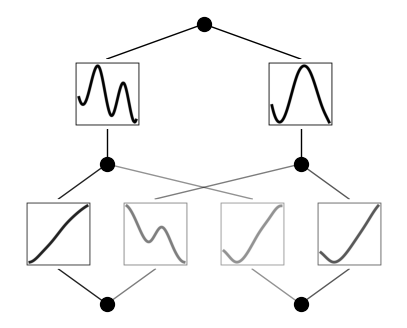

In [10]:
model.plot(beta=10)

Fix the first layer activation to be linear function, and the second layer to be sine functions (caveat: this is quite sensitive to hypreparams)

In [11]:
for i in range(2):
    for j in range(2):
        model.fix_symbolic(0,i,j,'x')
        
for i in range(2):
    model.fix_symbolic(1,i,0,'sin')

r2 is 0.9959412813186646
r2 is 0.7087432146072388
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.8844931721687317
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.8639693260192871
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.5367873907089233
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.9978556632995605


After setting all to be symbolic, we further train the model (affine parameters are still trainable). The model can now reach machine precision!

In [12]:
train()

pde loss: 6.58e+01 | bc loss: 8.96e-02 | l2: 4.88e-02 : 100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.86it/s]


Print out the symbolic formula

In [13]:
formula, var = model.symbolic_formula(floating_digit=5)
formula[0]

-0.5027*sin(-0.94724*x_1 + 3.27811*x_2 + 3.08365) + 0.2761*sin(6.3423*x_1 + 2.74657*x_2 + 9.46442) - 0.00848